In [7]:
# Imports
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import seaborn as sns
import time
import csv
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from PIL import Image

np.random.seed(42)

In [24]:
my_data_x = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_x.csv', delimiter=',')
my_data_y = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_y.csv', delimiter=',')
my_data_z = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_z.csv', delimiter=',')


# Load MagImage for deciding that where the data is and getting the width and Height of map
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

mag_training_data_xy = []
mag_training_data_z = []
for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            mag_training_data_xy.append([i*0.5, j*0.5]) # 0.5 means resolution when build magnetic map
            mag_training_data_z.append(my_data_x[i][j]*10+10)
mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)
data_size = mag_training_data_z.shape[0]

In [25]:
def calculate_dis(current_pos, data_pos):
    return math.hypot((current_pos[0]-data_pos[0]), current_pos[1]-data_pos[1])

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

batch_training_data_xy = np.empty(0)
batch_training_data_z = np.empty(0)
# m_max_size=0
# for i in range(0,data_size,3):
#     for j in range(data_size):
#         if(calculate_dis(mag_training_data_xy[i],mag_training_data_xy[j]) < 2.0):
#             k=k+1
#             batch_training_data_xy = np.append(batch_training_data_xy,mag_training_data_xy[j])
#             batch_training_data_z = np.append(batch_training_data_z,mag_training_data_z[j])

# i=327
# calculate_range=2.0

# for j in range(data_size):
#     if(calculate_dis(mag_training_data_xy[i],mag_training_data_xy[j]) < calculate_range):
#         batch_training_data_xy = np.append(batch_training_data_xy,mag_training_data_xy[j])
#         batch_training_data_z = np.append(batch_training_data_z,mag_training_data_z[j])
# batch_training_data_xy = np.reshape(batch_training_data_xy,[batch_training_data_z.shape[0],2])
# print("batch size: ",batch_training_data_z.shape[0])

In [26]:
# Generate Test Data
# batch_data_size=round(32/0.5)
# batch_test_data_range_x =np.linspace(mag_training_data_xy[i][0]-calculate_range, \
#                                      mag_training_data_xy[i][0]+calculate_range, batch_data_size)
# batch_test_data_range_y =np.linspace(mag_training_data_xy[i][1]-calculate_range, \
#                                      mag_training_data_xy[i][1]+calculate_range, batch_data_size)
# batch_test_data = np.zeros([batch_data_size*batch_data_size,2])
# for m in range(batch_data_size):
#     for n in range(batch_data_size):
#         batch_test_data[m*batch_data_size+n][0] = batch_test_data_range_x[m]
#         batch_test_data[m*batch_data_size+n][1] = batch_test_data_range_y[n]

In [27]:

# start_time = time.time()
# gp.fit(batch_training_data_xy, batch_training_data_z)
# print("---Pred: %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# y_pred, sigma = gp.predict(batch_test_data, return_std=True)
# print("---Fit:  %s seconds ---" % (time.time() - start_time))
# my_draw_test_data_x = batch_test_data[:,0].reshape(batch_data_size*batch_data_size,1)
# my_draw_test_data_y = batch_test_data[:,1].reshape(batch_data_size*batch_data_size,1)
# my_test_predict = y_pred.reshape(batch_data_size*batch_data_size,1)
# fig, ax = plt.subplots()

# _min, _max = np.amin(batch_training_data_z), np.amax(batch_training_data_z)
# sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict, cmap='rainbow', vmin = _min, vmax = _max)
# plt.colorbar()
# # sc = plt.scatter(batch_training_data_xy[:,0], batch_training_data_xy[:,1], c=batch_training_data_z, cmap='rainbow', vmin = _min, vmax = _max)
# plt.plot(batch_training_data_xy[:,0], batch_training_data_xy[:,1], 'ko')
# for i in range(len(batch_training_data_z)):
#     ax.annotate(round(batch_training_data_z[i],3), xy=(batch_training_data_xy[i][0],batch_training_data_xy[i][1]), color='black', 
#             xytext=(5,5), textcoords="offset points")
# # plt.savefig("scikit_GP_result.png")
# plt.show()

In [28]:
start_time = time.time()
gp.fit(mag_training_data_xy, mag_training_data_z)
print("---Pred: %s seconds ---" % (time.time() - start_time))


min_x = np.amin(mag_training_data_xy[:,0])
max_x = np.amax(mag_training_data_xy[:,0])
min_y = np.amin(mag_training_data_xy[:,1])
max_y = np.amax(mag_training_data_xy[:,1])

batch_data_size = int(round((max_x-min_x)/0.5))
batch_test_data_range_x =np.linspace(min_x, max_x, batch_data_size)
batch_test_data_range_y =np.linspace(min_y, max_y, batch_data_size)
batch_test_data = np.zeros([batch_data_size*batch_data_size,2])
for m in range(batch_data_size):
    for n in range(batch_data_size):
        batch_test_data[m*batch_data_size+n][0] = batch_test_data_range_x[m]
        batch_test_data[m*batch_data_size+n][1] = batch_test_data_range_y[n]

start_time = time.time()
y_pred, sigma = gp.predict(batch_test_data, return_std=True)
print("---Fit:  %s seconds ---" % (time.time() - start_time))

---Pred: 15.946264743804932 seconds ---
---Fit:  0.36301088333129883 seconds ---


<IPython.core.display.Javascript object>


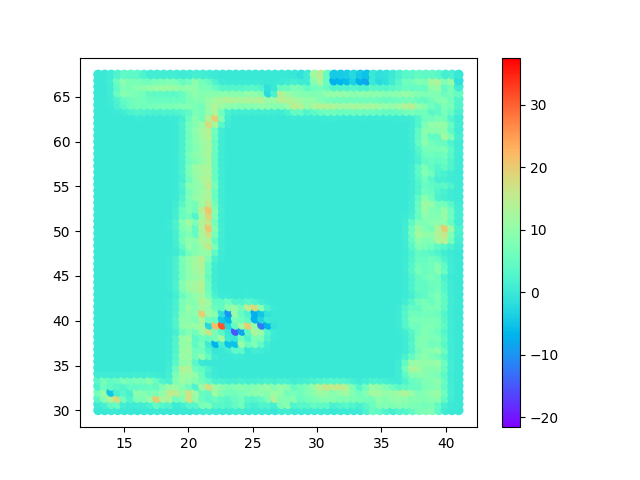

In [29]:
my_draw_test_data_x = batch_test_data[:,0].reshape(batch_data_size*batch_data_size,1)
my_draw_test_data_y = batch_test_data[:,1].reshape(batch_data_size*batch_data_size,1)
my_test_predict = y_pred.reshape(batch_data_size*batch_data_size,1)
fig, ax = plt.subplots()

_min, _max = np.amin(mag_training_data_z), np.amax(mag_training_data_z)
sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict, cmap='rainbow', vmin = _min, vmax = _max)
plt.colorbar()
# sc = plt.scatter(batch_training_data_xy[:,0], batch_training_data_xy[:,1], c=batch_training_data_z, cmap='rainbow', vmin = _min, vmax = _max)
# plt.plot(mag_training_data_xy[:,0], mag_training_data_xy[:,1], 'ko')
# for i in range(len(batch_training_data_z)):
#     ax.annotate(round(batch_training_data_z[i],3), xy=(batch_training_data_xy[i][0],batch_training_data_xy[i][1]), color='black', 
#             xytext=(5,5), textcoords="offset points")
# plt.savefig("scikit_GP_result.png")
plt.show()